In [9]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [12]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import shutil
import yaml
from rdkit import RDLogger
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

def read_yaml(yaml_path: str) -> MCTS:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    file_level = logging.DEBUG if conf.get("debug") else logging.INFO
    logger = make_logger(output_dir, file_level=file_level)
    generator_conf = conf.get("generator_conf", {})

    transition_conf = conf.get("transition_conf", {})
    if "model_dir" in transition_conf:
        transition_conf["model_dir"] = os.path.join(repo_root, transition_conf["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_conf["model_dir"])) + ".lang"
        lang_path = add_sep(transition_conf["model_dir"]) + lang_name
    lang = Language.load(lang_path)
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, device=conf.get("device"), **transition_conf)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_conf", {}))
    
    if "policy_class" in conf:
        policy_class = class_from_package("policy", conf.get("policy_class"))
        policy = policy_class(**conf.get("policy_conf", {}))
        generator_conf["policy"] = policy

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))
        
    root = MolSentenceNode.bos_node(lang, device=conf.get("device")) # TODO: change after root node generalization
    
    generator_class = class_from_package("generator", conf.get("generator_class", "MCTS"))
    generator = generator_class(root=root, transition=transition, reward=reward, filters=filters, filtered_reward=conf.get("filtered_reward"), output_dir=output_dir, logger=logger, **generator_conf)

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)
    return generator, conf

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_conf", {}))
    generator.analyze()

def queue_yaml(*args: str):
    for yaml_path in args:
        generator, conf = read_yaml(yaml_path)
        generate_and_analyze(generator, conf)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Is CUDA available: True
Starting generation...
generated: 100, time: 2.96, average over 100: 0.2385
generated: 200, time: 7.19, average over 100: 0.2387
generated: 300, time: 11.65, average over 100: 0.2549
generated: 400, time: 15.90, average over 100: 0.2275
generated: 500, time: 20.49, average over 100: 0.1945
generated: 600, time: 24.83, average over 100: 0.2281
generated: 700, time: 28.95, average over 100: 0.2624
generated: 800, time: 32.99, average over 100: 0.2429
generated: 900, time: 37.12, average over 100: 0.2473
generated: 1000, time: 41.72, average over 100: 0.1855
generated: 1100, time: 46.11, average over 100: 0.2493
generated: 1200, time: 50.67, average over 100: 0.1907
generated: 1300, time: 55.46, average over 100: 0.2227
generated: 1400, time: 59.91, average over 100: 0.2162
generated: 1500, time: 63.72, average over 100: 0.2256
generated: 1600, time: 68.26, average over 100: 0.2210
generated: 1700, time: 72.69, average over 100: 0.2324
generated: 1800, time: 77.19,

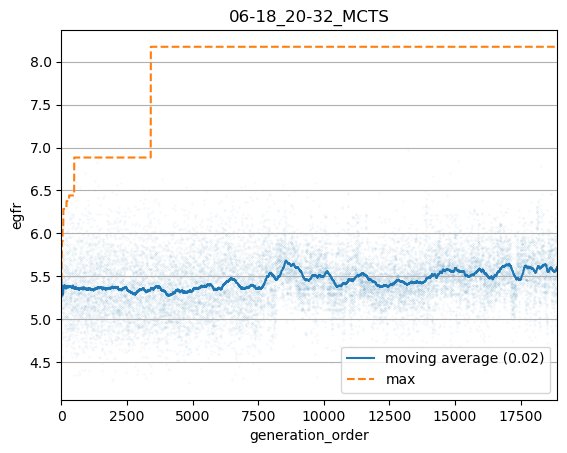

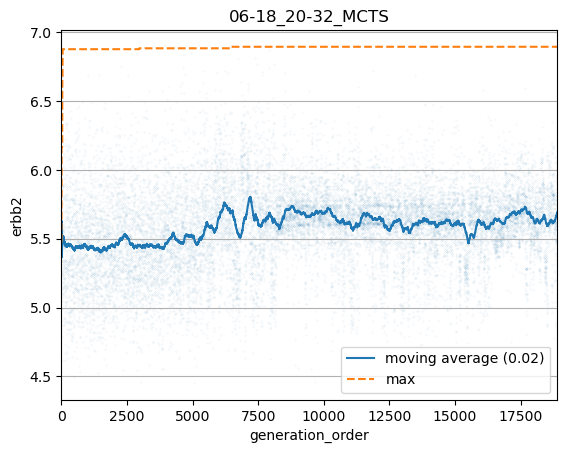

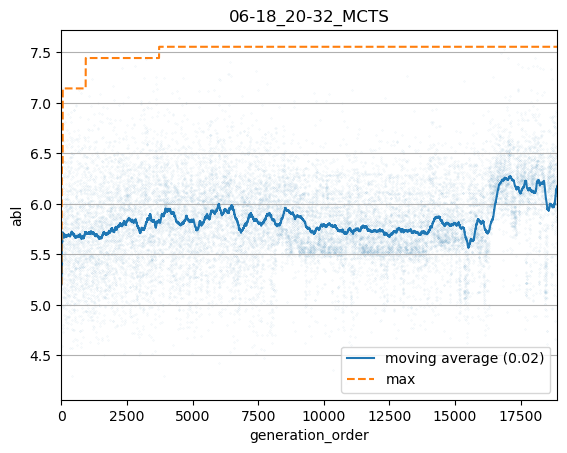

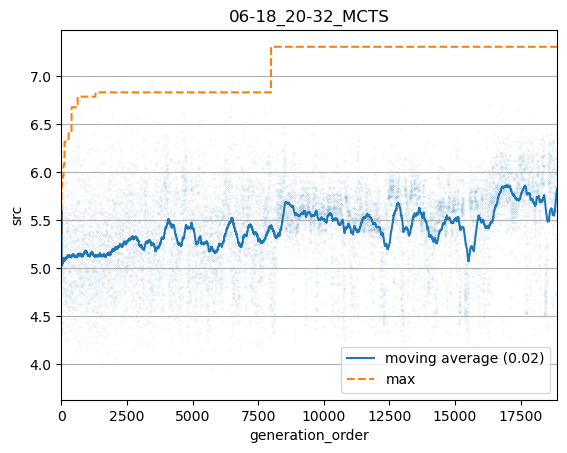

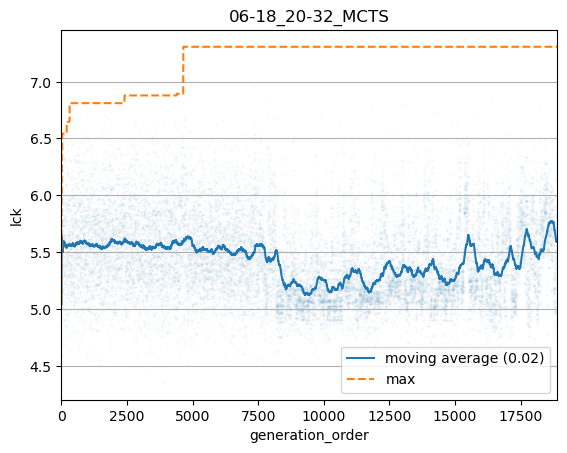

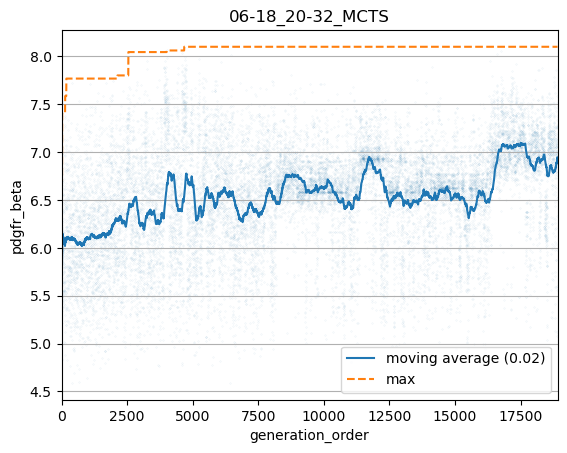

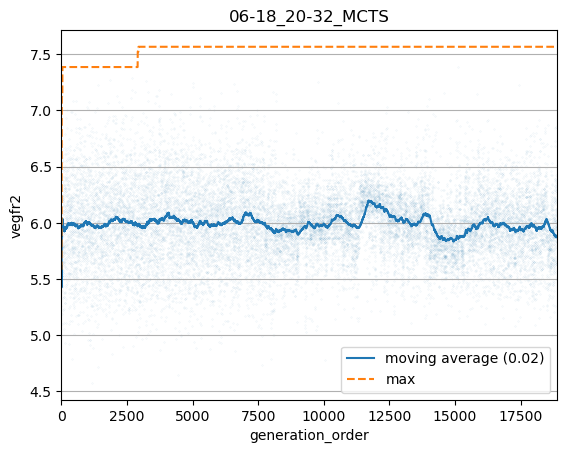

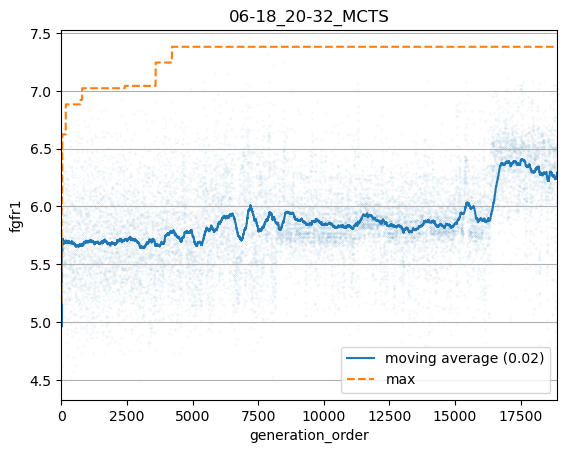

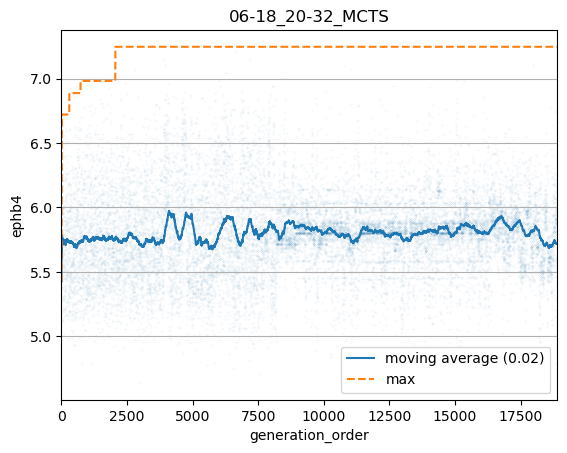

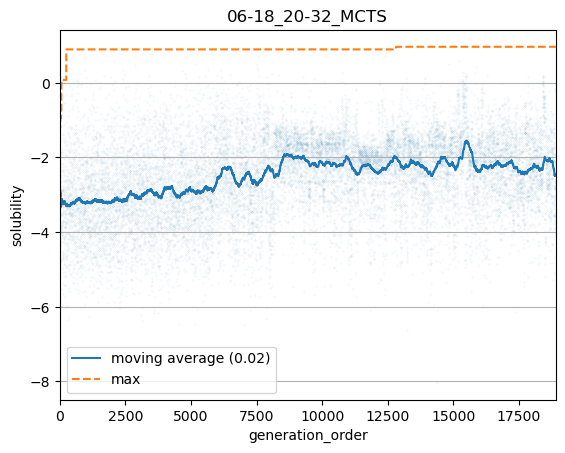

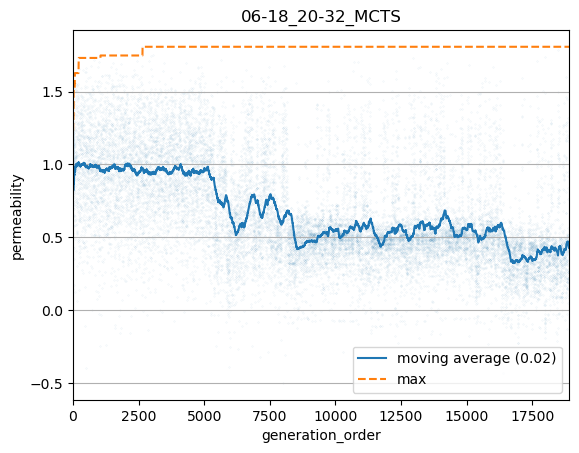

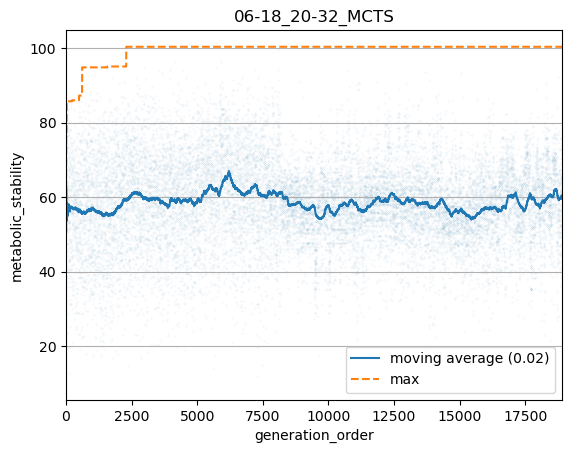

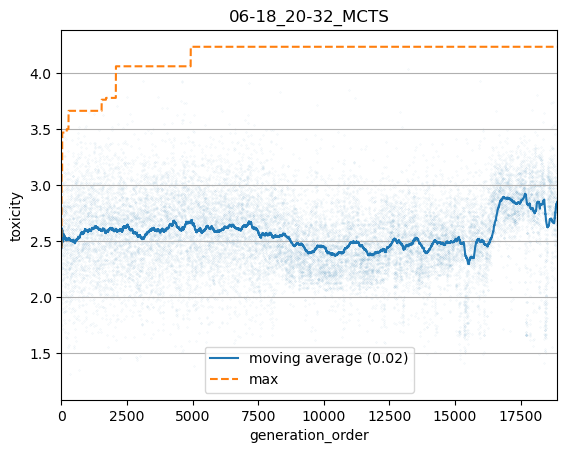

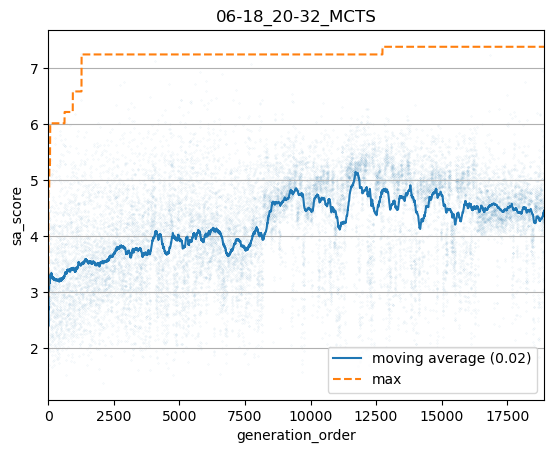

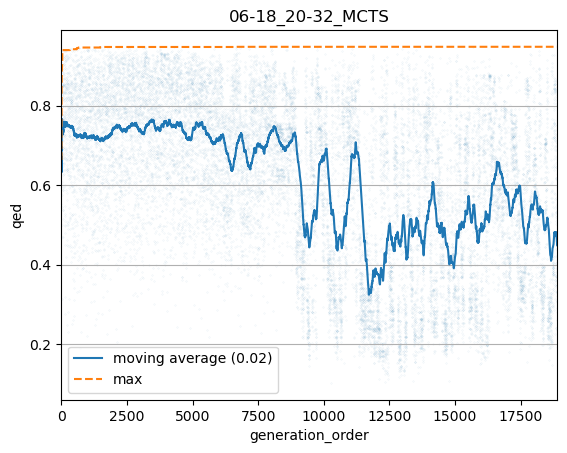

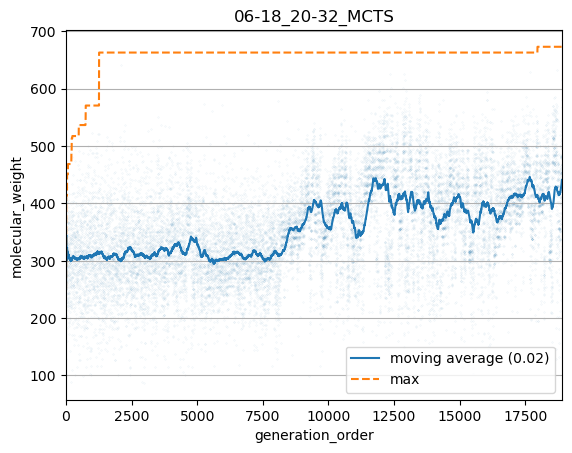

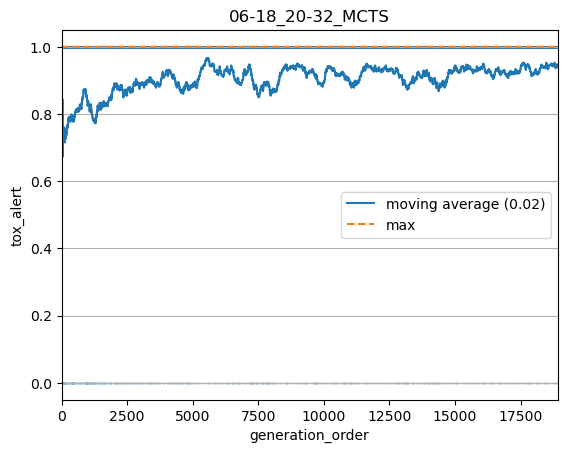

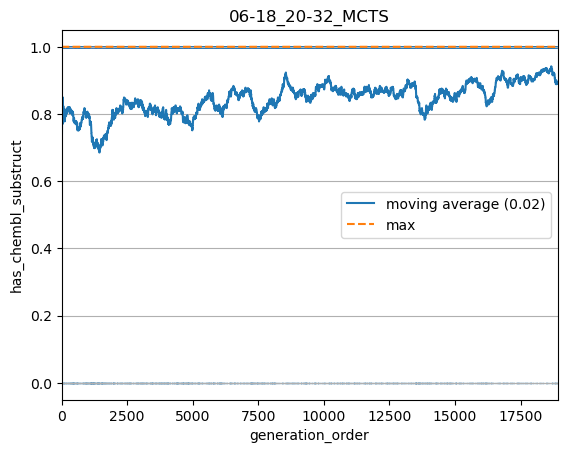

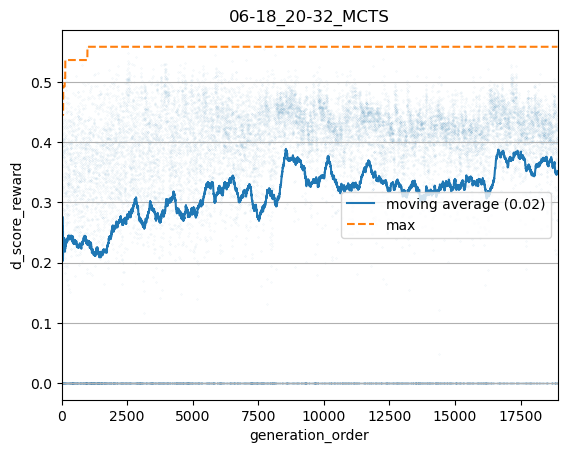

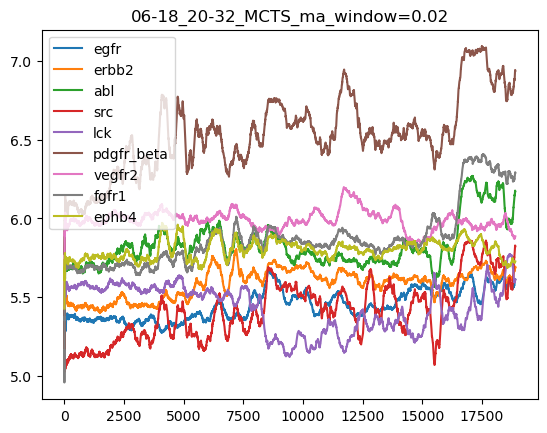

number of generated nodes: 18905
valid rate: 0.6134677991824347
unique rate: 0.8493133919173622
node_per_sec: 23.135720677540586


In [14]:
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
c3 = "config/mcts_smiles.yaml"
c4 = "config/model_test.yaml"
c5 = "config/mcts_d_score_diversion.yaml"
generator, conf = read_yaml(c5)
generate_and_analyze(generator, conf)
# queue_yaml(c1, c2)

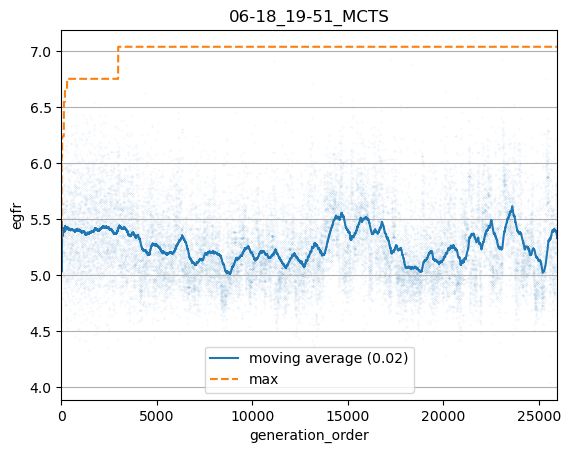

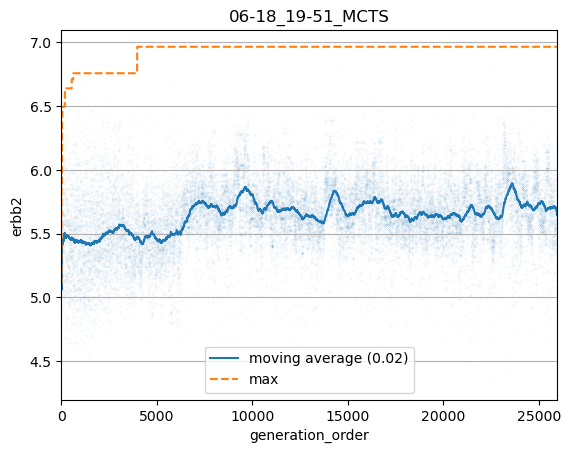

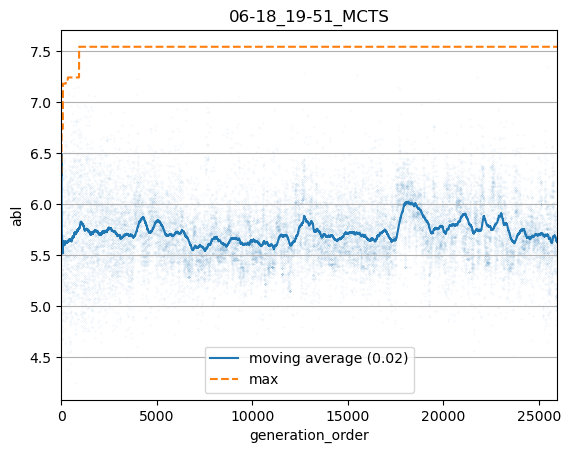

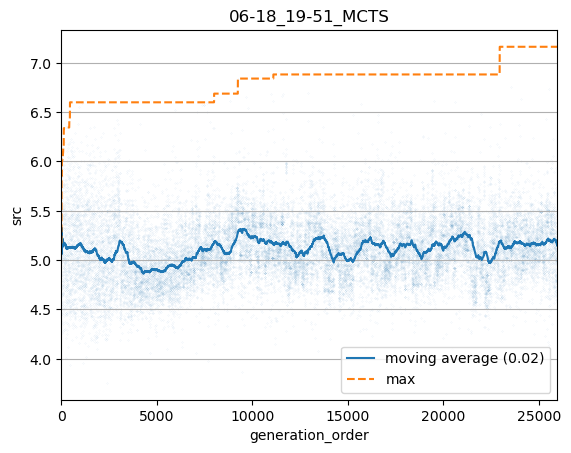

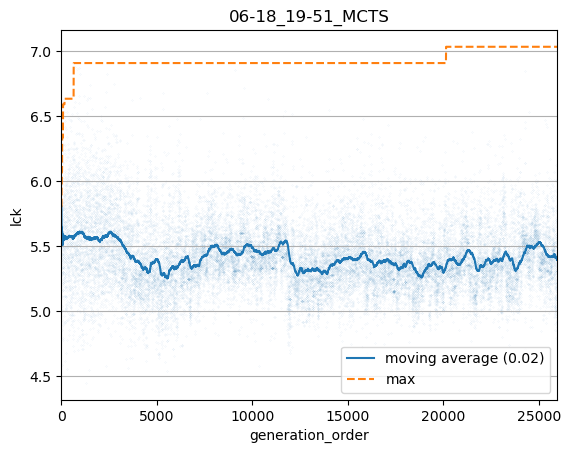

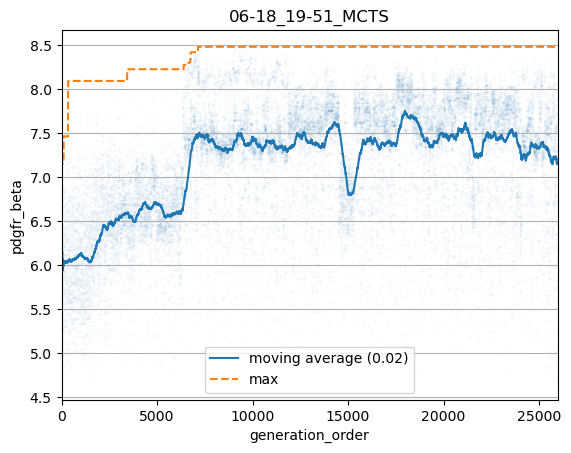

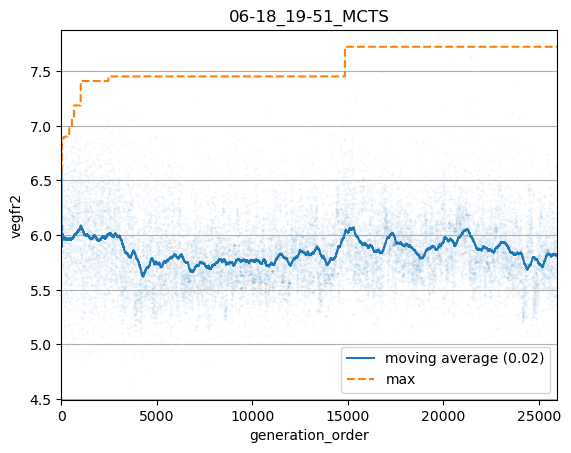

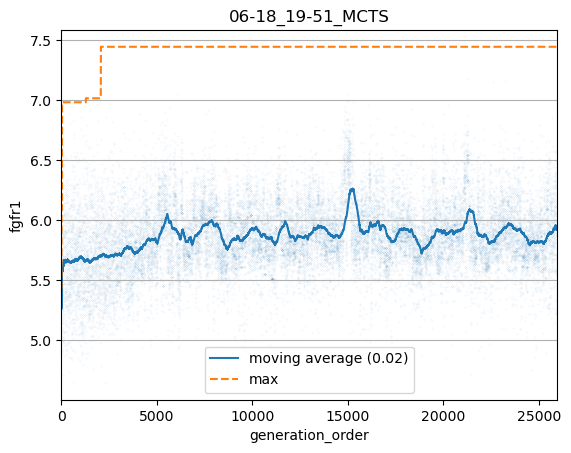

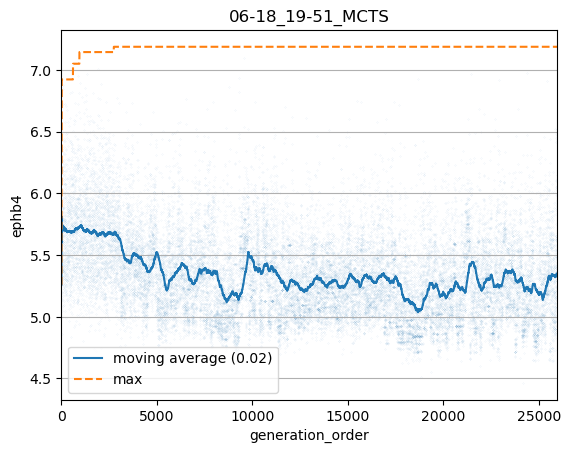

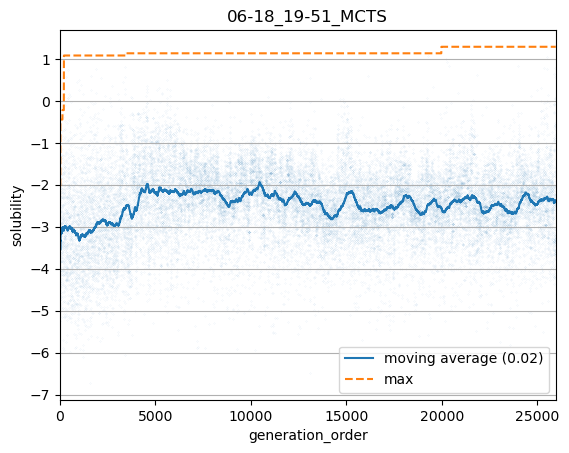

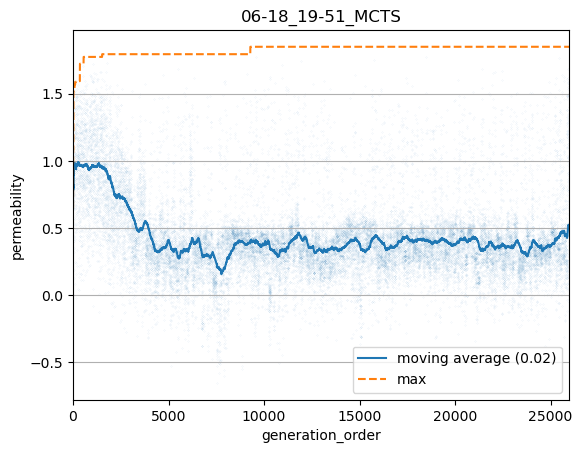

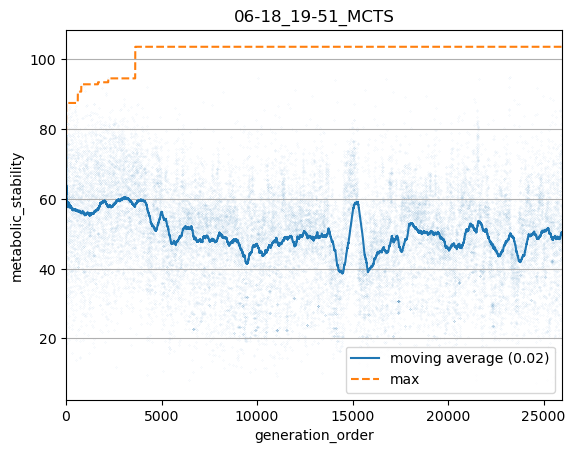

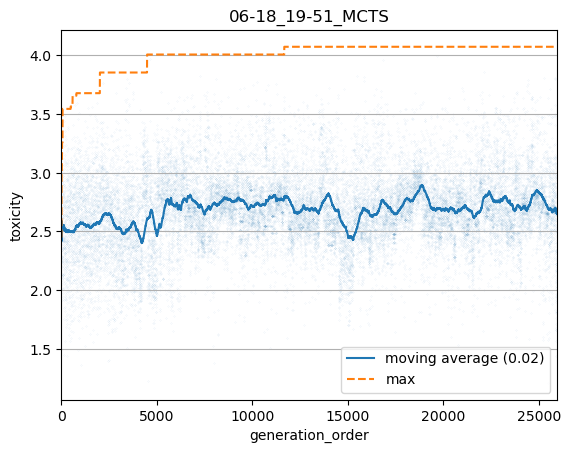

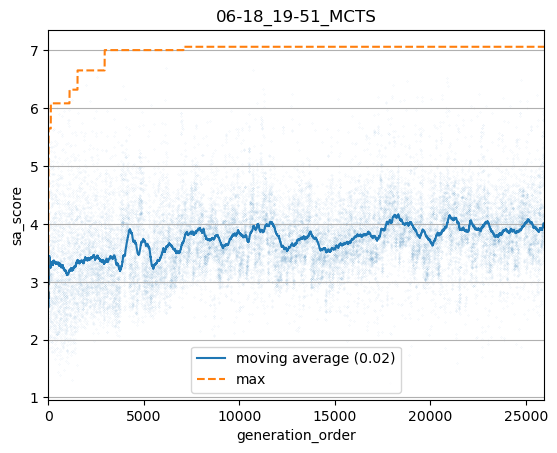

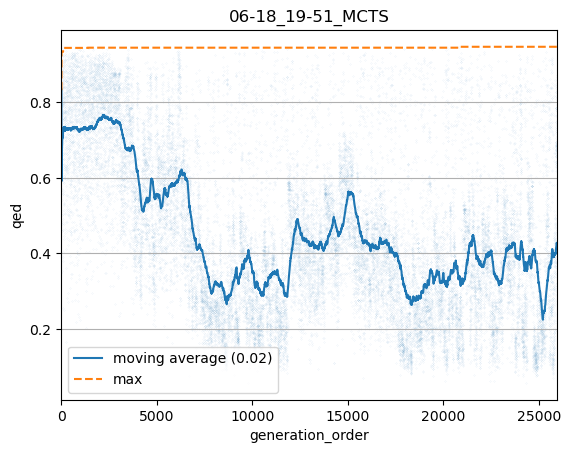

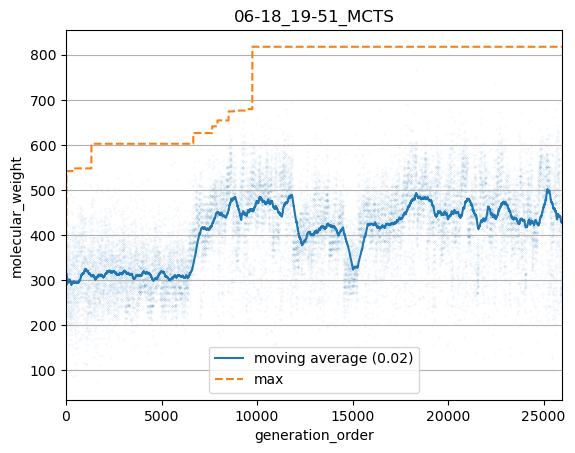

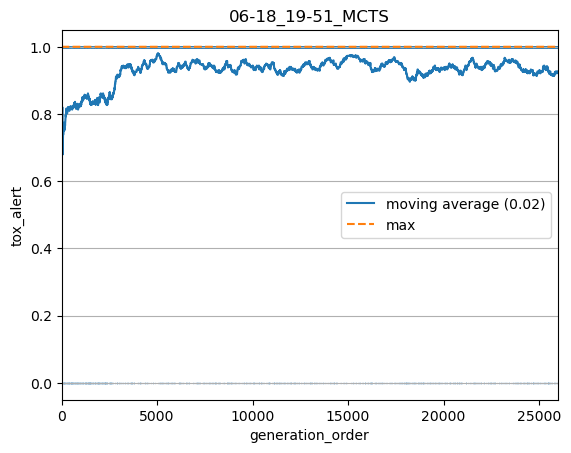

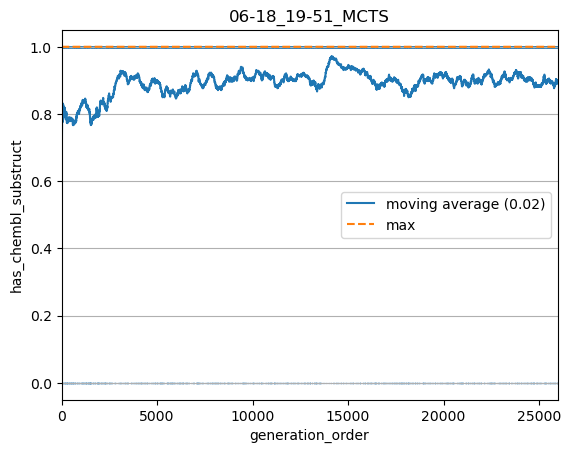

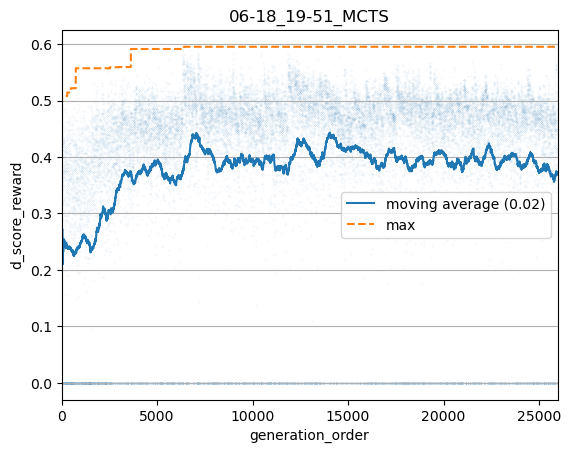

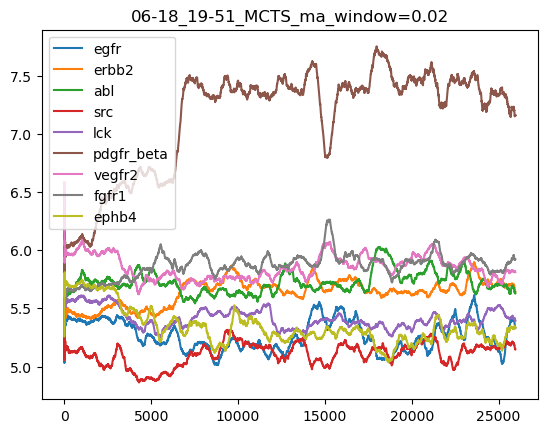

In [8]:
generator.plot(**conf.get("plot_conf", {}))

In [ ]:
#continue search
generator.generate(max_generations=10)
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [14]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts test
load_path = generator.output_dir() + "save.mcts"
generator = MCTS.load(load_path, generator.transition) #TODO: separate notebook

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
read_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)